In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['Admission_Predict_Ver1.1.csv', 'Admission_Predict.csv']


> ## If you find this notebook helpful , some upvotes would be very much appreciated -  That will keep me motivated  👍

# This kernel is split into 4 main topics:
## 1. Introduction 
## 2. Load and check data 
*     Load data
*     Outlier detection

## 3. Data Analysis
## 4. Modelling
*     Regression
*     Classification 

> ## 1. **INTRODUCTION **

# This kernel mainly focuses on what parameters are important for a student to get into a graduate school. By the end of this kernel it will be clear of what are the scores required for different tests to have better admission chances and get into a good graduate school.

![Grad](http://blogs.colum.edu/marginalia/files/2017/03/screen-shot-2017-03-09-at-2.20.49-pm.png)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
from matplotlib import pyplot

> ## 2. **LOADING DATA  AND CHECKING**

In [3]:
df=pd.read_csv('../input/Admission_Predict_Ver1.1.csv')

### Taking a look at our dataset for understanding

In [4]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [5]:
df=df.rename(columns = {'Chance of Admit ':'Chance of Admit'})

In [6]:
df.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit'],
      dtype='object')

In [7]:
df.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [8]:
df.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


### This gives us some intuition about all the columns and how are their values.

### Lets take a look at the outlier values and remove them 

In [9]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   
outliers_to_drop=detect_outliers(df,2,['GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research'])

Since outliers can have a dramatic effect on the prediction (especially for regression problems), I chose to manage them.

I used the Tukey method (Tukey JW., 1977) to detect ouliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). An outlier is a row that have a feature value outside the (IQR +- an outlier step).

I decided to detect outliers from the numerical values features (GRE Score, TOEFL Score, University Rating, SOP, LOR , CGPA, Research). Then, i considered outliers as rows that have at least two outlied numerical values

In [10]:
df.loc[outliers_to_drop] # Show the outliers rows

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit


## There are no outliers because all the values are inside a fixed range and none of them go lower/beyond that range which therefore produces no outliers

### Now we will try to find how the columns are inter related to each other 

In [11]:
cols=df.drop(labels='Serial No.',axis=1)
cols.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


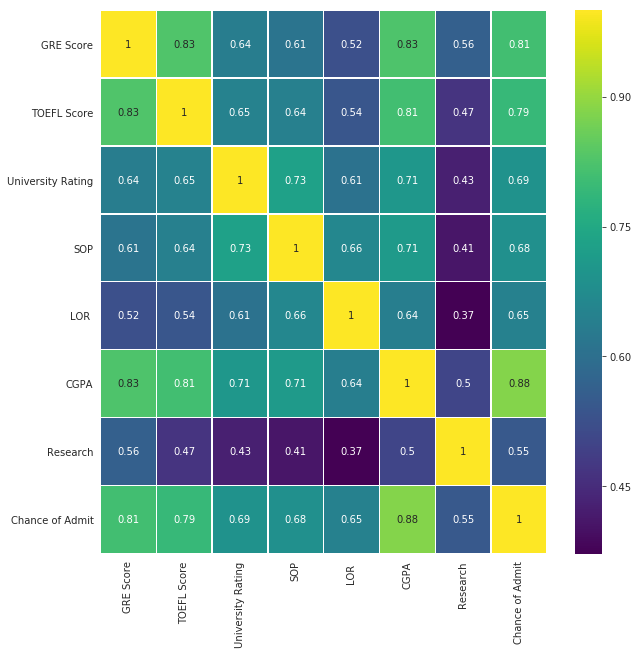

In [12]:
plt.figure(figsize=(10,10))
sns.heatmap(cols.corr(),cmap='viridis',annot=True,linewidths=0.5,)

Here we can see that the chance of admit is highly correlated with CGPA, GRE and TOEFEL scores are also correlated.

> ## 3. **DATA  ANALYSIS **

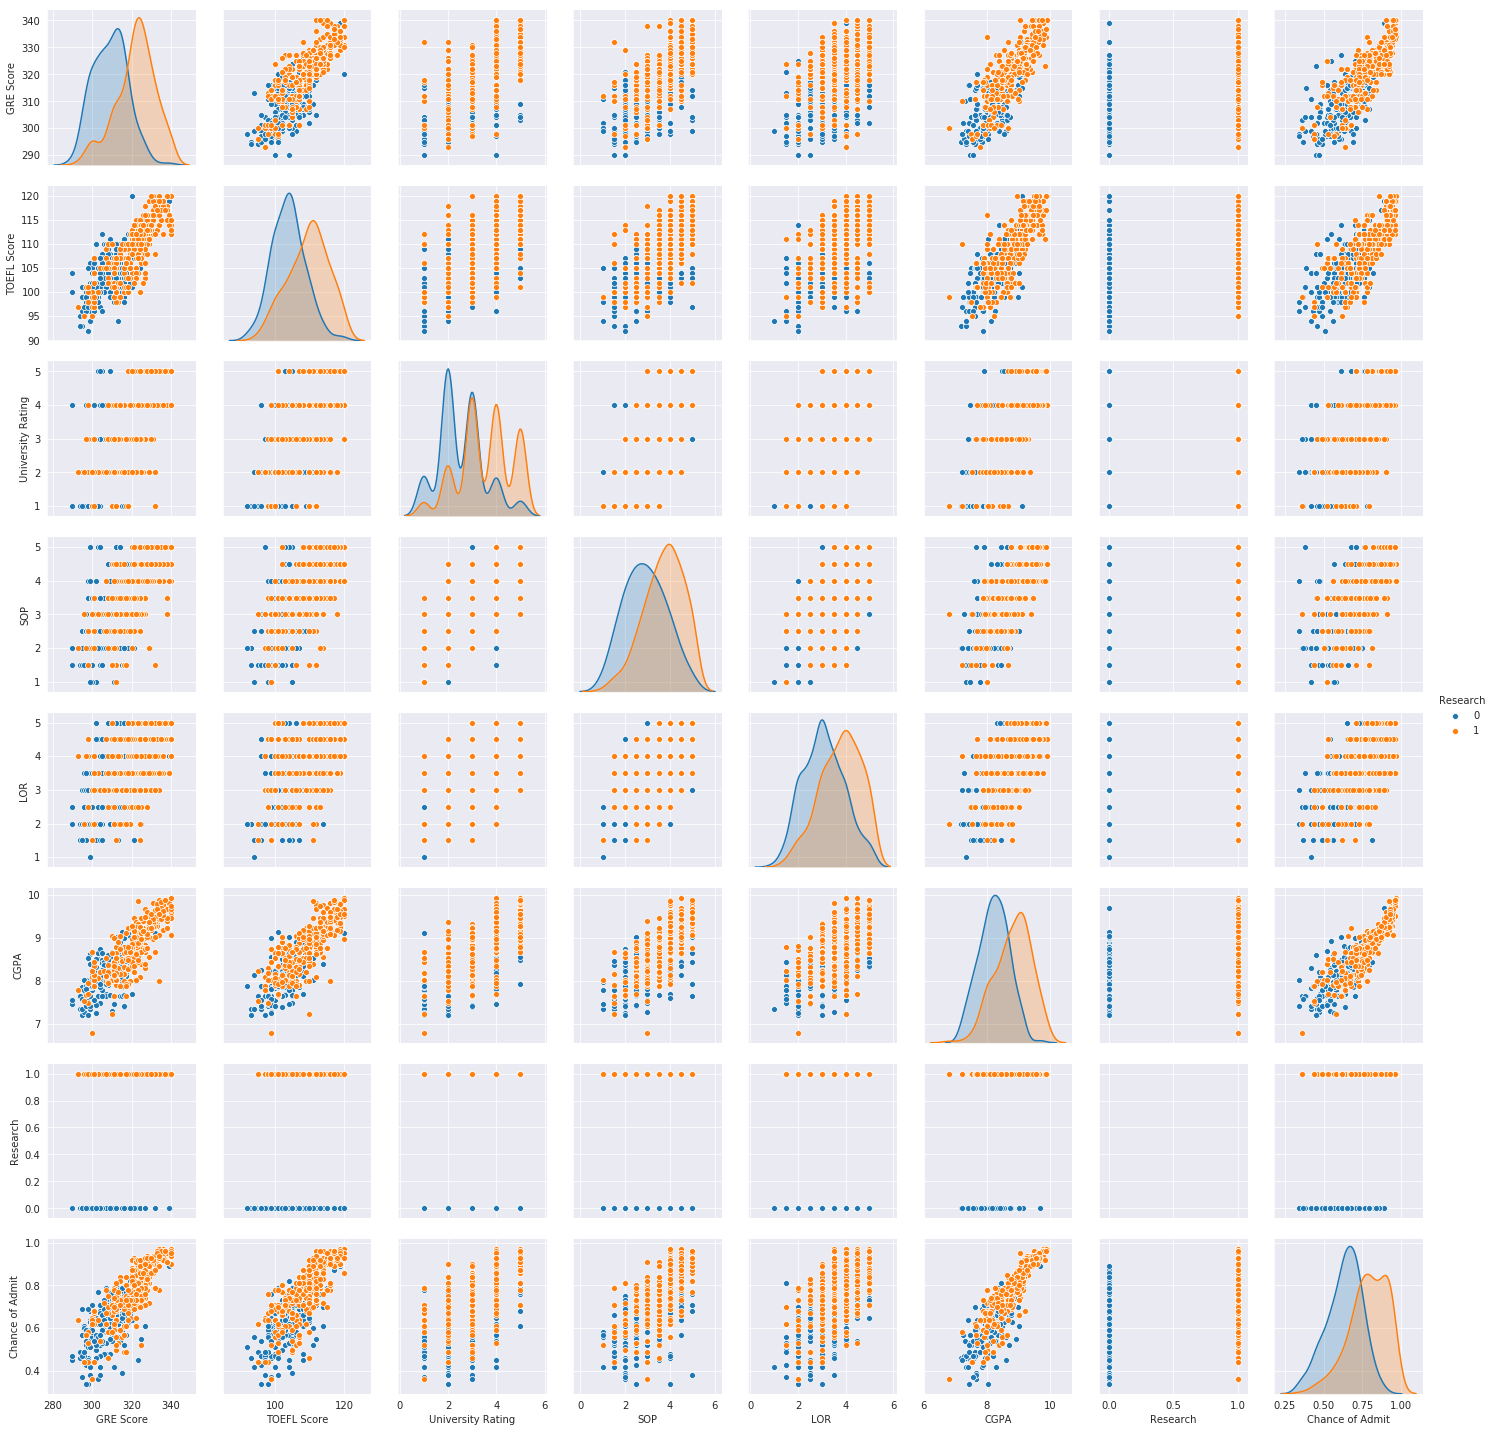

In [13]:
sns.pairplot(data=cols,hue='Research')

From the above pairplot its clearly visible that GRE score TOEFL score and CGPA all are linearly related to each other 
Also it can be inferred that Research Students tend to Score higher by all means

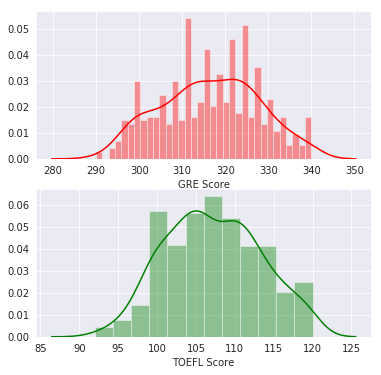

In [14]:
plt.figure(figsize=(6,6))
plt.subplot(2, 1, 1)
sns.distplot(df['GRE Score'],bins=34,color='Red')
plt.subplot(2, 1, 2)
sns.distplot(df['TOEFL Score'],bins=12,color='Green')

From the above 2 graphs its clear that people tend to score above 310 in GRE and above 100 in TOEFL

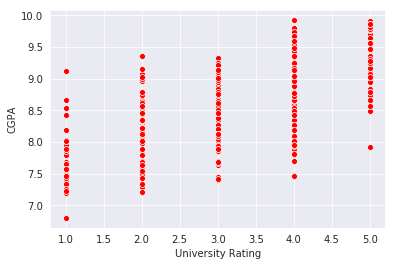

In [15]:
sns.scatterplot(x='University Rating',y='CGPA',data=df,color='Red')

Ratings of university increase with the increase in the CGPA

## Now lets set some cut-off scores and try to analyse scores above the cut-off

In [16]:
co_gre=df[df["GRE Score"]>=300]
co_toefel=df[df["TOEFL Score"]>=100]

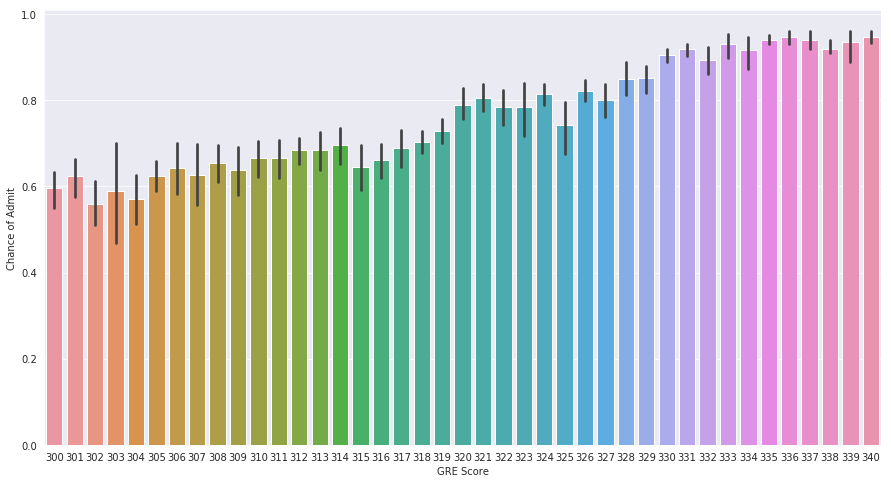

In [17]:
fig, ax = pyplot.subplots(figsize=(15,8))
sns.barplot(x='GRE Score',y='Chance of Admit',data=co_gre)
plt.show()

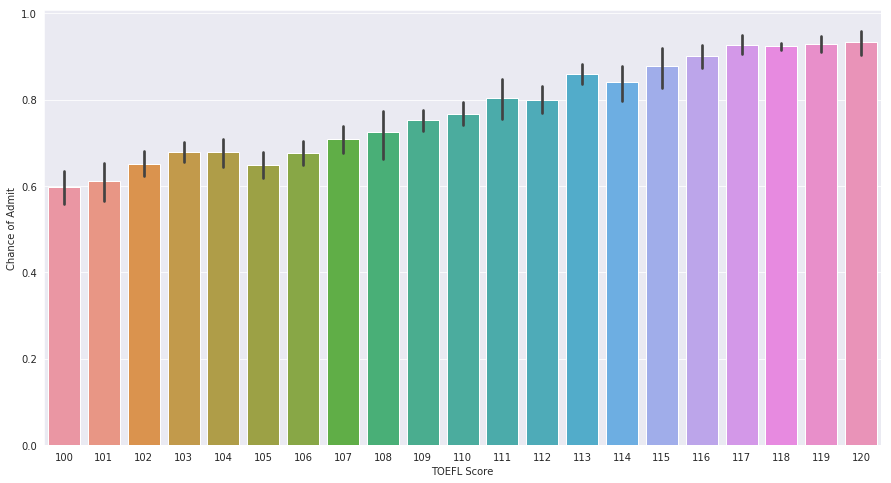

In [18]:
fig, ax = pyplot.subplots(figsize=(15,8))
sns.barplot(x='TOEFL Score',y='Chance of Admit',data=co_toefel)
plt.show()

The above two graphs make it clear that higher the Scores better the chance of admit

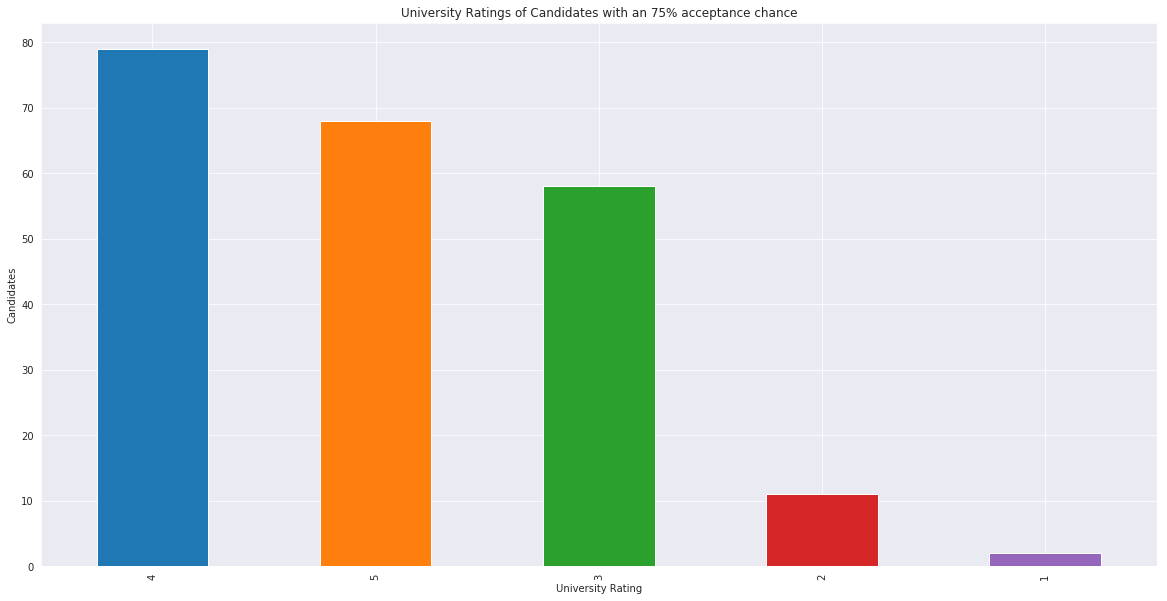

In [19]:
s = df[df["Chance of Admit"] >= 0.75]["University Rating"].value_counts().head(5)
plt.title("University Ratings of Candidates with an 75% acceptance chance")
s.plot(kind='bar',figsize=(20, 10))
plt.xlabel("University Rating")
plt.ylabel("Candidates")
plt.show()

In [20]:
print("Average GRE Score :{0:.2f} out of 340".format(df['GRE Score'].mean()))
print('Average TOEFL Score:{0:.2f} out of 120'.format(df['TOEFL Score'].mean()))
print('Average CGPA:{0:.2f} out of 10'.format(df['CGPA'].mean()))
print('Average Chance of getting admitted:{0:.2f}%'.format(df['Chance of Admit'].mean()*100))

Average GRE Score :316.47 out of 340
Average TOEFL Score:107.19 out of 120
Average CGPA:8.58 out of 10
Average Chance of getting admitted:72.17%


## Lets check out the toppers

In [21]:
df.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit'],
      dtype='object')

In [22]:
toppers=df[(df['GRE Score']>=330) & (df['TOEFL Score']>=115) & (df['CGPA']>=9.5)].sort_values(by=['Chance of Admit'],ascending=False)
toppers

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
202,203,340,120,5,4.5,4.5,9.91,1,0.97
143,144,340,120,4,4.5,4.0,9.92,1,0.97
24,25,336,119,5,4.0,3.5,9.80,1,0.97
203,204,334,120,5,4.0,5.0,9.87,1,0.97
213,214,333,119,5,5.0,4.5,9.78,1,0.96
385,386,335,117,5,5.0,5.0,9.82,1,0.96
148,149,339,116,4,4.0,3.5,9.80,1,0.96
81,82,340,120,4,5.0,5.0,9.50,1,0.96
496,497,337,117,5,5.0,5.0,9.87,1,0.96
23,24,334,119,5,5.0,4.5,9.70,1,0.95


> ## 4. **MODELLING **

Preparing the data for Regression 

In [23]:
# reading the dataset
df = pd.read_csv("../input/Admission_Predict.csv",sep = ",")

# it may be needed in the future.
serialNo = df["Serial No."].values

df.drop(["Serial No."],axis=1,inplace = True)

df=df.rename(columns = {'Chance of Admit ':'Chance of Admit'})

In [24]:
X=df.drop('Chance of Admit',axis=1)
y=df['Chance of Admit']

In [25]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Normalisation works slightly better for Regression.
X_norm=preprocessing.normalize(X)
X_train,X_test,y_train,y_test=train_test_split(X_norm,y,test_size=0.20,random_state=101)

In [26]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor,AdaBoostClassifier
from sklearn.ensemble import ExtraTreesRegressor,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.svm import SVR,SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score,mean_squared_error

# Regression

In [27]:
regressors=[['Linear Regression :',LinearRegression()],
       ['Decision Tree Regression :',DecisionTreeRegressor()],
       ['Random Forest Regression :',RandomForestRegressor()],
       ['Gradient Boosting Regression :', GradientBoostingRegressor()],
       ['Ada Boosting Regression :',AdaBoostRegressor()],
       ['Extra Tree Regression :', ExtraTreesRegressor()],
       ['K-Neighbors Regression :',KNeighborsRegressor()],
       ['Support Vector Regression :',SVR()]]
reg_pred=[]
print('Results...\n')
for name,model in regressors:
    model=model
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    rms=np.sqrt(mean_squared_error(y_test, predictions))
    reg_pred.append(rms)
    print(name,rms)

Results...

Linear Regression : 0.07697452196086574
Decision Tree Regression : 0.11755317945508748
Random Forest Regression : 0.07647900038572679
Gradient Boosting Regression : 0.07286293788761197
Ada Boosting Regression : 0.07825343080985663
Extra Tree Regression : 0.07718686740631465
K-Neighbors Regression : 0.09130553104823387
Support Vector Regression : 0.14620768513203117


In [28]:
y_ax=['Linear Regression' ,'Decision Tree Regression', 'Random Forest Regression','Gradient Boosting Regression', 'Ada Boosting Regression','Extra Tree Regression' ,'K-Neighbors Regression', 'Support Vector Regression' ]
x_ax=reg_pred

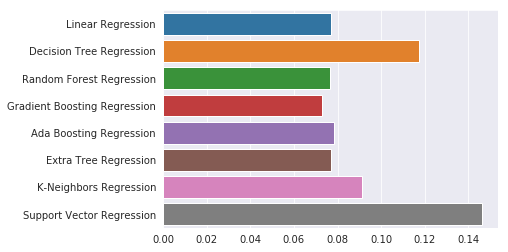

In [29]:
sns.barplot(x=x_ax,y=y_ax)

# Classification

In [30]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=101)

In [31]:
#If Chance of Admit greater than 80% we classify it as 1
y_train_c = [1 if each > 0.8 else 0 for each in y_train]
y_test_c  = [1 if each > 0.8 else 0 for each in y_test]

In [32]:
classifiers=[['Logistic Regression :',LogisticRegression()],
       ['Decision Tree Classification :',DecisionTreeClassifier()],
       ['Random Forest Classification :',RandomForestClassifier()],
       ['Gradient Boosting Classification :', GradientBoostingClassifier()],
       ['Ada Boosting Classification :',AdaBoostClassifier()],
       ['Extra Tree Classification :', ExtraTreesClassifier()],
       ['K-Neighbors Classification :',KNeighborsClassifier()],
       ['Support Vector Classification :',SVC()],
       ['Gausian Naive Bayes :',GaussianNB()]]
cla_pred=[]
for name,model in classifiers:
    model=model
    model.fit(X_train,y_train_c)
    predictions = model.predict(X_test)
    cla_pred.append(accuracy_score(y_test_c,predictions))
    print(name,accuracy_score(y_test_c,predictions))

Logistic Regression : 0.9125
Decision Tree Classification : 0.925
Random Forest Classification : 0.925
Gradient Boosting Classification : 0.9125
Ada Boosting Classification : 0.9125
Extra Tree Classification : 0.9625
K-Neighbors Classification : 0.9375
Support Vector Classification : 0.9375
Gausian Naive Bayes : 0.9375


In [33]:
y_ax=['Logistic Regression' ,
      'Decision Tree Classifier',
      'Random Forest Classifier',
      'Gradient Boosting Classifier',
      'Ada Boosting Classifier',
      'Extra Tree Classifier' ,
      'K-Neighbors Classifier',
      'Support Vector Classifier',
       'Gaussian Naive Bayes']
x_ax=cla_pred

Text(0.5,0,'Accuracy')

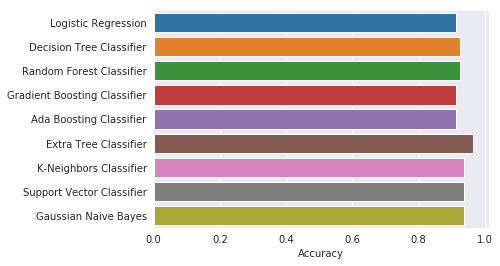

In [34]:
sns.barplot(x=x_ax,y=y_ax)
plt.xlabel('Accuracy')

# So the winner in Regression is : **Linear Regression **
# and the winner in Classification is :** Extra Tree Classifier**